<a href="https://colab.research.google.com/github/Manan-Parakh/CBTCIP-/blob/main/Iris_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# General Libraries
import pandas as pd
import numpy as np
import os
import sys
import sklearn

# For Plotting
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# To Store the pretty images we create
ROOT = "."
PROJECT_NAME = "IRIS_FLOWER_CLASSIFICATION"
IMAGES_PATH = os.path.join(ROOT, PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(figname, extension = "png", resolution = 300, tight_layout = True):
  path = os.path.join(IMAGES_PATH, figname + '.' + extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format = extension, dpi = 300)

# Dataset

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
X = iris.data
y = iris.target

In [ ]:
target_names = iris.target_names
feature_names = iris.feature_names
target_names, feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [ ]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Exploratory Data Analysis

In [ ]:
# PCA -> To reduce dimensions
# Model -> RFC, Boosted -> AdaBoost and GradientBoosting -> Find the best params for all of them and then compare their performances

In [ ]:
# Try to reduce dimensions of the dataset
from sklearn.decomposition import PCA
pca = PCA()
# Finding the best number of components to reduce the data to
for comp in range(1,4):
  pca.n_components = comp
  X2 = pca.fit_transform(X)
  print(comp, pca.explained_variance_ratio_)

1 [0.92461872]
2 [0.92461872 0.05306648]
3 [0.92461872 0.05306648 0.01710261]


In [ ]:
# Choosing n_components to be 2
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

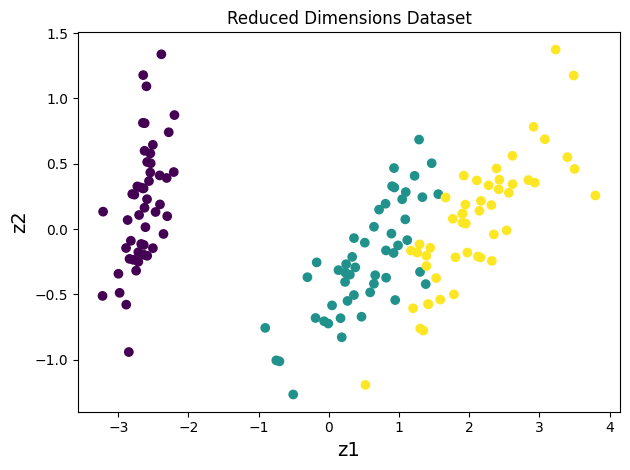

In [ ]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.xlabel("z1", fontsize = 14)
plt.ylabel("z2", fontsize = 14)
plt.title('Reduced Dimensions Dataset')
save_fig("Reduced_Dimensions_Dataset")

In [ ]:
# Split the dataset
# To ensure proper representation of all classes in the test and train set, we use StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2)
for train_index, test_index in split.split(X_reduced,y):
  X_train = X_reduced[train_index]
  X_test = X_reduced[test_index]
  y_train = y[train_index]
  y_test = y[test_index]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 2), (120,), (30, 2), (30,))

In [ ]:
# Training a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [ ]:
# We will use GridSearchCV to figure out the best possible parameters for our RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameter_grid = {"n_estimators": np.arange(1000,5000,1000),
                  "criterion": ['gini', 'entropy'],
                  "max_depth": range(1,5)}
grid = GridSearchCV(rnd_clf, parameter_grid, cv = 3)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 1000}

In [ ]:
rnd_clf = grid.best_estimator_
rnd_clf.oob_score = True
rnd_clf.fit(X_train, y_train)
rnd_clf.oob_score_

0.9333333333333333

In [49]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.94, 0.96, 0.96])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, rnd_clf.predict(X_test))

0.9

In [ ]:
# Let's save the model so that we don't have to train it again and again
import pickle
with open("rnd_clf.pkl", mode = 'wb') as file:
  pickle.dump(rnd_clf, file)

## Using ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier()
params_grid_extra = {"n_estimators": np.arange(500,2500,500),
                     "criterion": ['gini', 'entropy'],
                     "max_depth": range(1,7) ## Because RFC did its best at 4, so we must try greater values
                     }
grid_extra = GridSearchCV(extra_clf, params_grid_extra, cv = 3, n_jobs = -1)
grid_extra.fit(X_train,y_train)
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 1000}

In [ ]:
extra_clf = grid_extra.best_estimator_
extra_clf.oob_score = True
extra_clf.bootstrap = True
extra_clf.fit(X_train,y_train)
extra_clf.oob_score_

0.95

In [39]:
cross_val_score(extra_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.94, 0.98, 0.96])

In [41]:
accuracy_score(y_test, extra_clf.predict(X_test))

0.9

In [ ]:
with open("extra_clf.pkl", mode = 'wb') as file:
  pickle.dump(extra_clf, file)

# Using AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(estimator = rnd_clf)
params_grid_ada = {"learning_rate": [0.01, 0.1, 1, 10]}
grid_ada = GridSearchCV(ada_clf, params_grid_ada, cv = 3)
grid_ada.fit(X_train, y_train)
grid_ada.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

{'learning_rate': 1}

In [ ]:
ada_clf = grid_ada.best_estimator_
ada_clf.bootstrap = True
ada_clf.oob_score = True
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=4,
                                                         n_estimators=1000,
                                                         n_jobs=-1,
                                                         oob_score=True),
                   learning_rate=1)

In [ ]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.9

In [47]:
cross_val_score(ada_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.94, 0.94, 0.96])

In [ ]:
with open("ada_clf.pkl", mode = 'wb') as file:
  pickle.dump(ada_clf, file)

# Using Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_clf = GradientBoostingClassifier()
params_grid_gbc = {"n_estimators": np.arange(500,2500,500),
                   "learning_rate": [0.01, 0.1, 1, 10],
                   "max_depth": range(1,5)}
grid_gbc = GridSearchCV(gbc_clf, params_grid_gbc, cv = 3)
grid_gbc.fit(X_train,y_train)
grid_gbc.best_params_

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000}

In [ ]:
gbc_clf = grid_gbc.best_estimator_
gbc_clf.fit(X_train,y_train)
accuracy_score(gbc_clf.predict(X_test), y_test)

0.9

In [48]:
cross_val_score(gbc_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.96, 0.88, 0.98])

In [ ]:
with open("gbc_clf.pkl", mode ="wb") as file:
  pickle.dump(gbc_clf, file)

# Support Vector Machine